In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

from image_classification_file import ImageFolderWithPathsAndRatings, ImageFolderWithPaths

In [2]:
"""
SCRIPT GLOBAL VARS
"""
# root directory where the images are stored
data_dir = "/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump"#/Fall"#/Dump"
# ratings = None
limit_num_pictures = False #limit_num_pictures = 2000
rated_indices = []
ratings = []
bad_indices = []
# we load the pretrained model, the argument pretrained=True implies to load the ImageNet weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)

In [3]:
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
print("Head of indices: {}".format(indices[:10]))

split = int(np.floor(valid_size * num_pictures))
print("Split index: {}".format(split))

# may be unnecessary with the choice of sampler below
np.random.shuffle(indices)
print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split] #rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
            sampler=train_sampler, batch_size=1)#, num_workers=4)
print("Train loader length: {}".format(len(train_loader)))
test_loader = torch.utils.data.DataLoader(test_data,
            sampler=test_sampler, batch_size=1)#, num_workers=4)
print("Test loader length: {}".format(len(test_loader)))

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

vgg16.to(device) # loads the model onto the device (CPU or GPU)

Number of pictures in subdirectories: 69704
Head of indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Split index: 13940
Head of shuffled indices: [20377, 50352, 63102, 46762, 11747, 22036, 26952, 50638, 53851, 19360]
Size of training set: 55764, size of test set: 13940
Train loader length: 55764
Test loader length: 13940
Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 8)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

vgg16.load_state_dict(torch.load('models/Jan16_All_2017_Fall_Dump_only_labels.pt'))

<All keys matched successfully>

In [5]:
# limit_num_pictures = 13940
# vgg16.eval()

# print(len(test_loader))

# for i, data in enumerate(test_loader):
#     if limit_num_pictures:
#         if i > limit_num_pictures:
#             break
#     # inputs, _, path, label = data
#     inputs, _, _, _ = data
#     # print(label)
#     output = vgg16(inputs)
#     # loss = criterion(output, label)

#     # running_loss += loss.item()
#     _, preds = torch.max(output.data, 1)
#     print(preds)
#     # num_correct += (preds == label).sum().item()
#     print("Classification for test image #{}: {}".format(i, output))


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170906_CartwrightPresser_EJ/20170906_CartwrightPresser_EJ_038.JPG
Classification for test image #0: [2118.699462890625, -3091.189697265625, -627.711181640625, 93.74707794189453, 1944.5037841796875, -185.52456665039062, -174.0181427001953, -78.76846313476562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


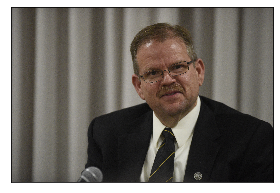


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170922_RockBridgeFootball_OL/20170922_RockbridgeFootball_OL_458.JPG
Classification for test image #1: [10375.0048828125, -612.3225708007812, -6263.86474609375, -2529.467041015625, -340.27197265625, -265.9552307128906, -250.0724639892578, -113.06288146972656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ743.JPG
Classification for test image #2: [10017.21875, -765.249267578125, -6435.12255859375, -723.5250854492188, -1761.0545654296875, -140.02606201171875, -131.67132568359375, -59.72557067871094]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170922_RockBridgeFootball_OL/20170922_RockbridgeFootball_OL_533.JPG
Classification for test image #3: [17065

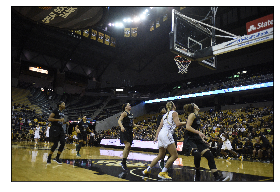


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170821_Eclipse_jd/20170821_Eclipse_CoopersLanding_jd_280.JPG
Classification for test image #21: [6009.83349609375, -2249.7978515625, -2179.2900390625, 838.5675048828125, -2060.771484375, -151.9529266357422, -142.60189819335938, -64.9480972290039]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_059.JPG
Classification for test image #22: [12019.2666015625, -6199.4658203125, -4684.86962890625, -724.9003295898438, 236.7051239013672, -273.6404724121094, -257.50738525390625, -116.04058074951172]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSoccer_EJ_525.JPG
Classification for test image 

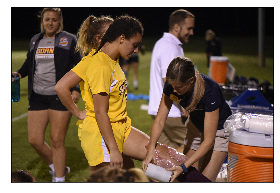


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170903_horseshoe_JJ/20170903_Horseshoe_JJ_059.JPG
Classification for test image #41: [4554.67333984375, -2731.41796875, 110.69227600097656, -1907.653076171875, 324.4638671875, -148.027099609375, -139.1225128173828, -63.422119140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_quidditch_JJ/20170930_quidditch_JJ_022.JPG
Classification for test image #42: [3470.593994140625, 935.6241455078125, -2328.5986328125, -684.7055053710938, -685.9483032226562, -299.36492919921875, -281.75689697265625, -127.41958618164062]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171002_MissouriHonorFlight_jd/20171002MissouriHonorFlight_jd_180.JPG
Classification for test image #43: [4368.4365234375, 646

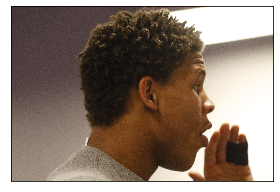


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PetExpo_OL/20170826_PetExpo_OL_167.JPG
Classification for test image #61: [2535.283935546875, 418.5464782714844, 108.60462951660156, -1058.03173828125, -1512.877685546875, -207.3210906982422, -195.3048858642578, -88.5790786743164]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_882.JPG
Classification for test image #62: [2728.044677734375, -1896.0836181640625, 43.84754943847656, -733.7445068359375, 131.91737365722656, -115.5772476196289, -108.48896789550781, -49.12468719482422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171009_PaigeBedsworth_EJ/20171009_PaigeBedsworth_EJ_841.JPG
Classification for test image #63: [4323.865234375, -2060.399

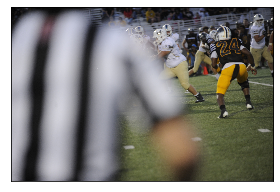


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensSoccer_OL_1576.JPG
Classification for test image #81: [10313.0595703125, -227.59144592285156, -6920.44677734375, -30.7183837890625, -2582.905029296875, -233.5959014892578, -219.765869140625, -99.27904510498047]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171201_voxspaelite_JJ/20171201_voxsalonelite_jj_047.JPG
Classification for test image #82: [9672.7060546875, -2728.8203125, -5221.5517578125, -1541.28857421875, 568.6983032226562, -316.2225646972656, -297.273681640625, -134.52308654785156]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171107_honorflight_ec/20171107_honorflight_ec_035.JPG
Classification for test image #83: [3772.291748046875,

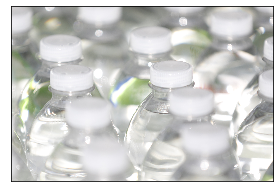


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_mktbridges_nc/20170921_mktbridges_nc_079.JPG
Classification for test image #101: [4380.27099609375, 561.677734375, -3634.973388671875, -173.79617309570312, -838.922119140625, -124.38792419433594, -116.47666931152344, -52.72883605957031]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171015_featurehunt_JJ/20171015_featurehunt_JJ_094.JPG
Classification for test image #102: [4274.0576171875, -1212.66455078125, -1548.09912109375, -653.9144287109375, -434.11749267578125, -180.2388458251953, -169.09457397460938, -76.67488861083984]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCelebration_EJ/20171209_KwanzaaCelebration_EJ_285.JPG
Classification for test image #103: [5265.3

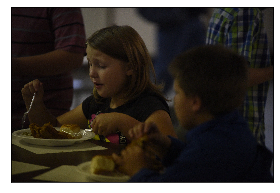


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_tailgate_ec/20170916_tailgate_ec_003.JPG
Classification for test image #121: [3139.621826171875, -63.96528244018555, 265.1663818359375, 113.08517456054688, -2896.23828125, -236.43704223632812, -222.5016326904297, -100.65410614013672]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensSoccer_OL_828.JPG
Classification for test image #122: [10954.423828125, -1216.7828369140625, -6359.31884765625, 225.29119873046875, -3079.71240234375, -221.72216796875, -208.15554809570312, -94.01342010498047]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171016_featurehuntbindersschisler_nc/20171016_featurehuntbinderschisler_nc_004.JPG
Classification for test ima

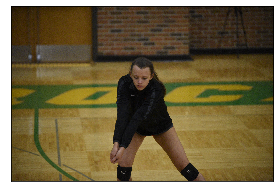


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171204_NancyThompsonProfile_EJ/20171204_NancyThompsonProfile_EJ_020.JPG
Classification for test image #141: [4614.3173828125, 585.8236083984375, -2946.7421875, -1122.5203857421875, -765.7952880859375, -153.9560546875, -144.83079528808594, -65.77957916259766]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_776.JPG
Classification for test image #142: [7123.982421875, -1349.3828125, -3308.9814453125, -1346.530029296875, -789.5320434570312, -138.93572998046875, -130.63450622558594, -59.362396240234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171004_BattleFootballPractice_EJ/20171004_BattleFootballPractice_EJ_029.JPG
Classification for 

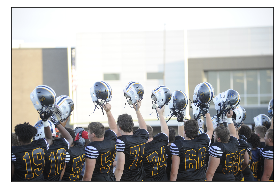


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171208_coleysholidaydrinks_JJ/20171208_coleysholidaydrinks_JJ_006.JPG
Classification for test image #161: [8588.72265625, -1322.5330810546875, -4295.5263671875, -846.7537841796875, -1725.084228515625, -168.40460205078125, -157.68844604492188, -71.68859100341797]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_961.JPG
Classification for test image #162: [17869.23828125, -41.8770866394043, -14265.83984375, -3386.705078125, 639.6678466796875, -344.8310546875, -323.66693115234375, -147.1217803955078]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171201_livingwindows_ec/20171201_livingwindows_ec_112.JPG
Classification for test image #163: [

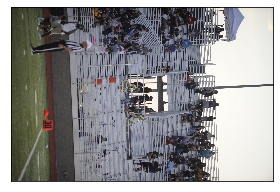


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171021_madness_nc/20171021_madness_nc_175.JPG
Classification for test image #181: [12868.7021484375, 603.2713623046875, -8530.353515625, -1822.185546875, -2591.60546875, -222.31695556640625, -209.109375, -95.05799102783203]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170929_fridaynightsights_nc/20170929_fridaynightsights_nc_214.JPG
Classification for test image #182: [14273.232421875, -1748.3409423828125, -10651.634765625, -868.4716186523438, -580.6058959960938, -179.1856689453125, -168.06259155273438, -76.53700256347656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstewartlate_JJ_049.JPG
Classification for test image #183: [4580.96533203125, 915.0423

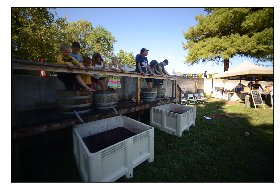


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_126.JPG
Classification for test image #201: [8730.0380859375, -1896.0374755859375, -6912.28857421875, 1722.82421875, -1286.418212890625, -150.77334594726562, -142.06732177734375, -64.3847885131836]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170911_HickmanVolleyball_jd/20170911_HickmanVolleyball_jd_022.JPG
Classification for test image #202: [11509.83984375, -1455.2762451171875, -5017.072265625, -2930.193603515625, -1306.67431640625, -338.3426208496094, -317.9564208984375, -144.1316680908203]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_hickmanvolleyball_nc/20170921_hickmanvolleyball_nc_161.JPG
Classification for test image #203: [16542.7050

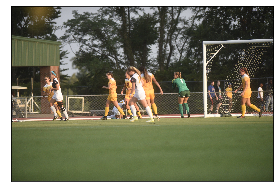


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ063.JPG
Classification for test image #221: [9656.431640625, 619.6296997070312, -9561.0595703125, -276.55767822265625, -34.913818359375, -170.69955444335938, -160.17242431640625, -72.63640594482422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171201_livingwindows_ec/20171201_livingwindows_ec_064.JPG
Classification for test image #222: [3473.579833984375, -155.7173309326172, 47.94990539550781, -618.719482421875, -1869.167724609375, -370.73162841796875, -348.7460632324219, -157.76165771484375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171030_BoonePointApartments_EJ/20171030_BoonePointApartments_EJ_124.JPG
Classification for test image #22

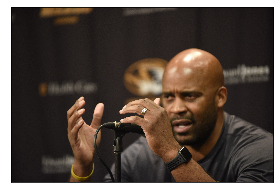


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_699.JPG
Classification for test image #241: [5584.994140625, -253.58387756347656, -3077.64794921875, -515.0098876953125, -1110.8121337890625, -265.2507019042969, -248.8732147216797, -112.36400604248047]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171004_BattleFootballPractice_EJ/20171004_BattleFootballPractice_EJ_011.JPG
Classification for test image #242: [14217.201171875, -1311.111328125, -11068.1787109375, -1673.292236328125, 414.59527587890625, -244.67184448242188, -229.94021606445312, -104.47630310058594]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_2205.JPG
Classification for test image #

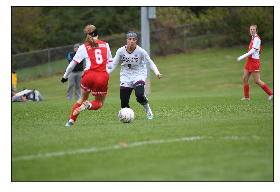


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171113_InHomeImpact_EJ/20171113_InHomeImpact_EJ_048.JPG
Classification for test image #261: [3448.890625, 338.2850036621094, -2457.240478515625, -1152.54443359375, 309.53155517578125, -205.18894958496094, -193.044189453125, -87.1277847290039]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171004_RockBridgeVolleyball_jd/20171004_RockBridgeVolleyball_jd_190.JPG
Classification for test image #262: [3376.978759765625, 2664.552734375, -2744.798095703125, -664.7197265625, -1791.2646484375, -355.3924255371094, -333.7635192871094, -150.95001220703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170823_BattleSoftball_OL/20170823_Battlesoftball_OL_090.JPG
Classification for test image #263: [8110.562

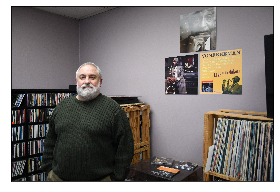


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_353.JPG
Classification for test image #281: [9547.8427734375, -6912.806640625, -3475.2509765625, -2643.717041015625, 3873.017578125, -164.4071044921875, -154.52395629882812, -69.7442855834961]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170922_RockBridgeFootball_OL/20170922_RockbridgeFootball_OL_126.JPG
Classification for test image #282: [14486.947265625, -1415.116455078125, -9836.1298828125, -2584.23583984375, 78.44023895263672, -308.1527099609375, -289.900146484375, -131.92161560058594]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_700.JPG
Classification for test image #283: [5832

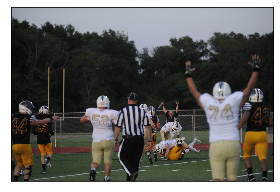


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171002_mudvolleyball_jd/20171002CAFNRmudvolleyball_jd_043.JPG
Classification for test image #301: [6141.34765625, 1157.79541015625, -4153.84716796875, -1282.3350830078125, -1199.7833251953125, -280.1742858886719, -263.4006652832031, -119.16277313232422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170901_VoxFall_JJ/20170901_VoxFall_JJ_042.JPG
Classification for test image #302: [7221.755859375, -7087.23876953125, 4654.83154296875, -2102.718017578125, -2143.736328125, -229.0894775390625, -215.66848754882812, -96.51897430419922]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171202_veteransunited_nc/20171202_Vox_veteransunited_NC_040.JPG
Classification for test image #303: [4666.66015625, 1

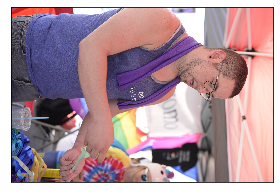


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171030_BoonePointApartments_EJ/20171030_BoonePointApartments_EJ_014.JPG
Classification for test image #321: [7633.82080078125, -855.6824340820312, -6632.72998046875, -573.17529296875, 982.956787109375, -234.75186157226562, -219.8767852783203, -99.45332336425781]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_702.JPG
Classification for test image #322: [1813.5228271484375, -3.5889554023742676, -1654.744384765625, -187.34129333496094, 502.16143798828125, -199.1219940185547, -186.86395263671875, -84.48429107666016]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_452.JPG
Classification for test image #323: [4634

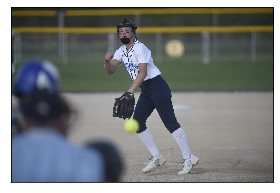


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_quidditch_JJ/20170930_quidditch_JJ_109.JPG
Classification for test image #341: [8372.3427734375, -150.71461486816406, -4371.29833984375, -1478.0706787109375, -1548.9022216796875, -349.26031494140625, -327.47686767578125, -148.36923217773438]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171027_BattleFB_FNS_EJ/20171027_BattleFB_FNS_EJ_734.JPG
Classification for test image #342: [11963.0234375, -2137.453369140625, -8515.36328125, -2093.163818359375, 1287.1412353515625, -212.67958068847656, -199.50173950195312, -91.16902923583984]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ981.JPG
Classification for test image #343: [6273.7958984375, 1228

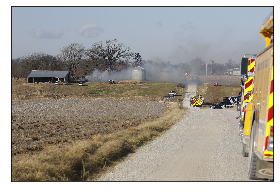


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_207.JPG
Classification for test image #361: [3368.760498046875, -651.7817993164062, -1041.620361328125, 210.03541564941406, -1245.595947265625, -271.2192077636719, -255.3915252685547, -115.4552230834961]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170915_Novakannouncement_JJ/20170915_novakannouncement_JJ_362.JPG
Classification for test image #362: [4387.73046875, -51.5787467956543, -4718.46728515625, -1241.491455078125, 2066.825927734375, -187.20362854003906, -175.78256225585938, -79.5286636352539]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ907.JPG
Classification for te

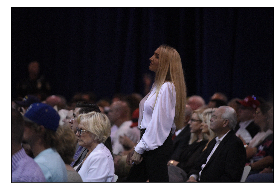


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170910_steamengineshow_jj/20170910_steamengineshow_jj_059.JPG
Classification for test image #381: [2267.542236328125, 215.6731414794922, -1046.073486328125, -1932.6181640625, 802.6370239257812, -129.94277954101562, -121.41644287109375, -55.643577575683594]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170922_battlefootball_Ec/20170922_fridaynightsights_ec_619.JPG
Classification for test image #382: [18341.296875, -3299.397705078125, -13210.634765625, -1628.69775390625, 567.8308715820312, -326.0858154296875, -306.1964111328125, -139.02215576171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_592.JPG
Classification for test image #383

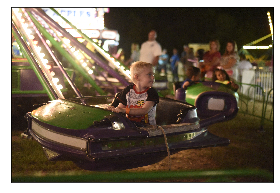


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_2259.JPG
Classification for test image #401: [3338.234619140625, 610.1604614257812, -1001.2979736328125, -285.8350830078125, -2088.6533203125, -242.28469848632812, -227.5127410888672, -102.90650177001953]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170828_StephensVolleyball_jd/20170828_StephensVolleyball_jd_074.JPG
Classification for test image #402: [13078.091796875, -2312.335205078125, -8510.9462890625, 683.9716796875, -2310.34423828125, -265.17144775390625, -248.892578125, -112.45172119140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171027_BattleFB_FNS_EJ/20171027_BattleFB_FNS_EJ_099.JPG
Classification for test image #403: [10404.

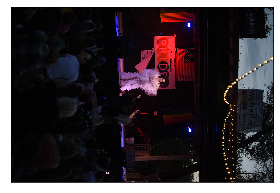


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0428.JPG
Classification for test image #421: [3121.562255859375, 3149.56591796875, -6919.42626953125, -2048.175048828125, 3466.08154296875, -326.2452697753906, -306.47137451171875, -138.76486206054688]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ1200.JPG
Classification for test image #422: [2696.489013671875, 1879.16015625, -3447.92578125, 1241.469970703125, -1656.0, -301.6315002441406, -284.22723388671875, -128.2148895263672]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171005_rbvb_nc/20171005_rbvb_nc_057.JPG
Classification for test image #423: [14402.6162109375, -3353.60888671875, -6756.8334960937

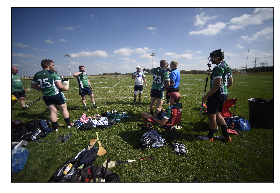


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_549.JPG
Classification for test image #441: [9109.83984375, -1976.8287353515625, -5050.2275390625, -914.8935546875, -679.65185546875, -206.12310791015625, -193.71368408203125, -87.6858901977539]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171008_crushfestival_JJ/20171008_crushfestival_JJ_134.JPG
Classification for test image #442: [338.2627258300781, -34.57148361206055, 121.65737915039062, -1324.2928466796875, 1249.025390625, -147.95590209960938, -139.3669891357422, -63.294227600097656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171012_battlefootballpracticefeature_nc/20171012_battlefootballpracticefeature_nc_068.JPG
Classificatio

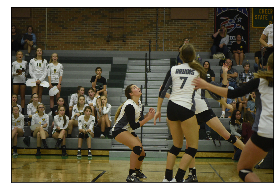


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170929_mubaseballfeaturemattkane_nc/20170929_mubaseballfeaturemattkane_nc_114.JPG
Classification for test image #461: [698.726806640625, -1214.384765625, 1207.1968994140625, 0.8514404296875, -281.49798583984375, -173.71434020996094, -163.6875, -74.18708801269531]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSoccer_EJ_384.JPG
Classification for test image #462: [11680.0263671875, -765.8726806640625, -8220.0703125, 1156.10546875, -3357.377685546875, -208.86355590820312, -195.68870544433594, -88.30443572998047]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171011_Vox_BeerStudio_jd/20171011_Voxbeer_jd_151.JPG
Classification for test imag

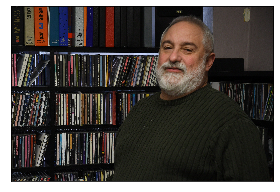


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_291.JPG
Classification for test image #481: [9529.94140625, -1831.1248779296875, -4708.13037109375, -1745.13134765625, -702.2708129882812, -229.38052368164062, -215.43118286132812, -97.55903625488281]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171027_RockBridge_ec/20171027_rockbridge_Ec_0074.JPG
Classification for test image #482: [10010.3251953125, 621.1103515625, -9725.6044921875, -1169.9727783203125, 740.311279296875, -201.3095245361328, -189.31202697753906, -85.66217803955078]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstewartlate_JJ_435.JPG
Classification for test image #483: [16745.07617187

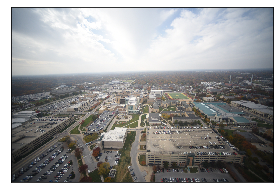

In [6]:
limit_num_pictures = 500
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, label = data
    path = path[0]
    label = torch.LongTensor([int(label[0])])

    output = vgg16(inputs)
    loss = criterion(output, label)

    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
    print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(8):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 20 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

testing_loss = running_loss/len(test_loader.dataset)
testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')


In [7]:
# ratings_data.set_index('file_path')
ratings_data

1            2  \
file_path                                                                       
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   2118.699463 -3091.189697   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  10375.004883  -612.322571   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  10017.218750  -765.249268   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  17065.601562 -1724.707275   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   4020.646973  2757.557373   
...                                                          ...          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   6074.189941   -23.968975   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...    408.732452  1590.116089   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  10342.315430  1166.889038   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   4282.519043  1453.752319   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   4213.241211   599.654358   

                                                               3            4  \
file_path                                                                       
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   -627.711182    93.747078   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -6263.864746 -2529.467041   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -6435.122559  -723.525085   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -13349.238281  -341.181000   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -3476.945068    39.571960   
...                                                          ...          ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -5181.997559 -1099.962280   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -1405.799683  -436.291534   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -6381.120605 -1028.553101   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -5163.921387   -61.370541   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -2611.521484  -875.521362   

                                                              5           6  \
file_path                                                                     
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  1944.503784 -185.524567   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -340.271973 -265.955231   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -1761.054565 -140.026062   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -970.141113 -288.177887   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -2791.633545 -232.276398   
...                                                         ...         ...   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   901.456055 -282.715851   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   522.151550 -286.836609   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -3164.471191 -395.026245   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...   -41.440315 -198.062653   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa...  -907.840271 -175.930054   

                                                             7           8  
file_path                                                                   
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -174.018143  -78.768463  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -250.072464 -113.062881  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -131.671326  -59.725571  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -270.335693 -122.463356  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -217.970428  -98.658302  
...                                                        ...         ...  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -265.504150 -120.415352  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -269.448853 -121.789268  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -370.846283 -167.881027  
/mnt/md0/mysql-dump-economists/Archives/2017/Fa... -185.671204  -84.028793  
/mn

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa756c07b10>,
      dtype=object)

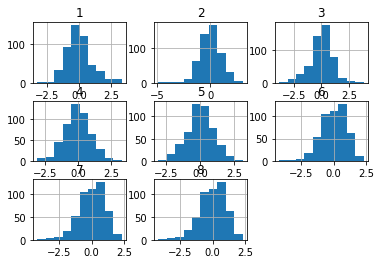

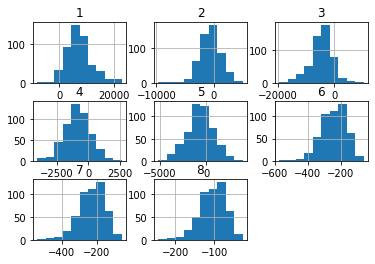

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
space_1 = scaler.fit_transform(ratings_data)
ratings_data_norm = pd.DataFrame(space_1, columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

In [9]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

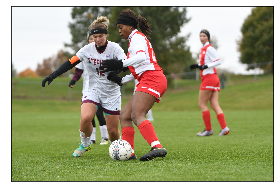

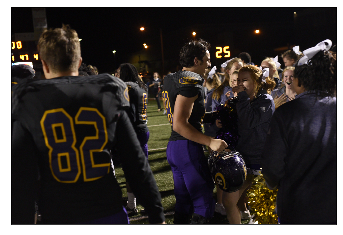

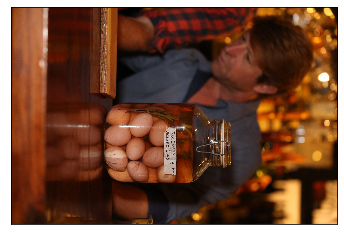

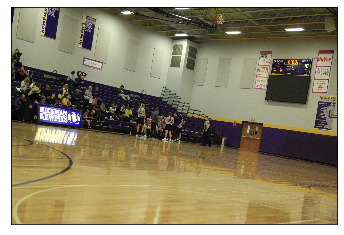

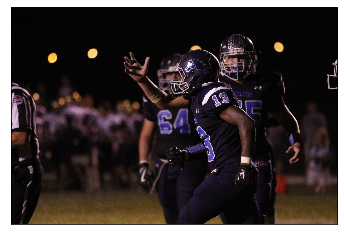

In [10]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

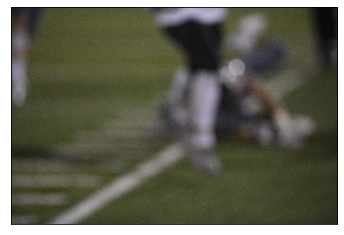

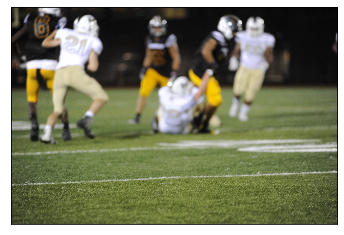

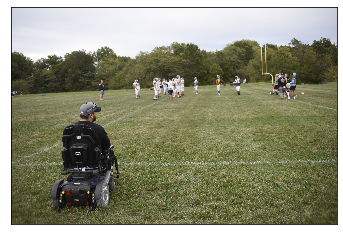

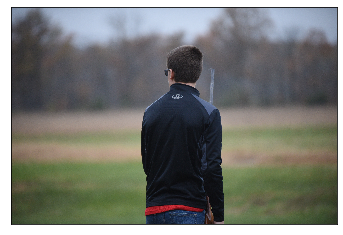

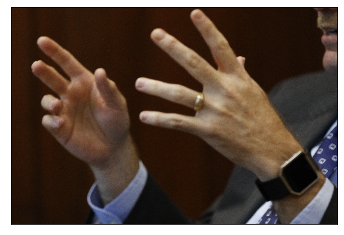

In [11]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()